In [754]:
import sys
assert sys.version_info >= (3,5)

In [755]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [756]:
import pandas as pd

In [757]:
import numpy as np

In [758]:
import scipy.stats as stats

In [759]:
import matplotlib.pyplot as plt
%matplotlib inline

In [760]:
from pandas.plotting import scatter_matrix

In [761]:
import time

In [762]:
import cv2

In [763]:
import seaborn as sns

In [764]:
import warnings
warnings.filterwarnings('ignore')

In [765]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

In [766]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [767]:
from sklearn.metrics import accuracy_score, silhouette_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

In [768]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB 

In [769]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [770]:
from sklearn.model_selection import cross_val_score

In [771]:
from itertools import cycle

In [772]:
from sklearn.cluster import KMeans

In [773]:
complete_x_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_train_all.csv')
complete_y_train=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_train_all.csv')
complete_x_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/x_test_all.csv')
complete_y_test=pd.read_csv('./Traffic_Sign/CompleteDataSet/y_test_all.csv')

In [774]:
complete_x_train = complete_x_train.copy().astype('float') / 255
complete_x_test = complete_x_test.copy().astype('float') / 255

In [775]:
joined_dataset = complete_x_train.copy()
joined_dataset['class']=complete_y_train.copy()

grouped_dataset = joined_dataset.groupby('class', group_keys=False)
avg_val = int(grouped_dataset['class'].value_counts().max())

In [776]:
balanced_dataset = pd.DataFrame()

for i in range(0,10):
        balanced_dataset = pd.concat([balanced_dataset, joined_dataset[joined_dataset['class']==i].sample(avg_val, replace=True)])

balanced_dataset_x = balanced_dataset.iloc[:,:48*48]
balanced_dataset_y = balanced_dataset.iloc[:,48*48:]

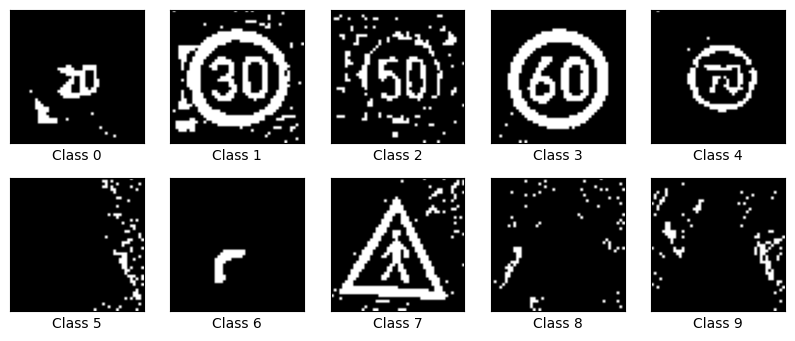

In [777]:
import cv2
import numpy as np

def remove_noise_and_background(image_path):
    image = cv2.equalizeHist(image_path.reshape(48,48))
    
    image_8bit = cv2.convertScaleAbs(image)
    
    smoothed_image = cv2.GaussianBlur(image_8bit, (3, 3), 0)
    
    _, thresholded_image = cv2.threshold(smoothed_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    main_object = max(contours, key=cv2.contourArea)
    
    mask = np.zeros_like(image)
    cv2.drawContours(mask, [main_object], -1, (255, 0, 0), thickness=cv2.FILLED)
    
    object_with_removed_background = cv2.bitwise_and(image, mask)
    
    return object_with_removed_background


def img_denoiser(arr): 
    reshaped_array = arr 
    normalized_array = np.uint8(reshaped_array*255)
    if normalized_array.ndim != 2:
        raise ValueError("The image should have 2 dimensions")
    thresholded_image = cv2.adaptiveThreshold(cv2.resize(normalized_array,(48,48)), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 3)
    return thresholded_image

upgraded = [remove_noise_and_background(img_denoiser(i.reshape(48,48))).reshape(-1,48*48) for i in np.array(balanced_dataset_x)]
upgraded = [i[0] for i in upgraded]

plt.figure(figsize=(10,4))

img_toshow = [0,210,2435,6085,7030,8275,8635,8875,9415,9685]

for i in range (0, len(img_toshow)):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(remove_noise_and_background(img_denoiser(np.array(complete_x_train.iloc[img_toshow[i]]).reshape(48,48))), cmap='gray')
    plt.xlabel("Class "+str(complete_y_train.iloc[img_toshow[i]].to_numpy()[0]))

In [778]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', random_state = 42, n_init=10)
kmeans.fit(upgraded)

KMeans(n_clusters=10, n_init=10, random_state=42)

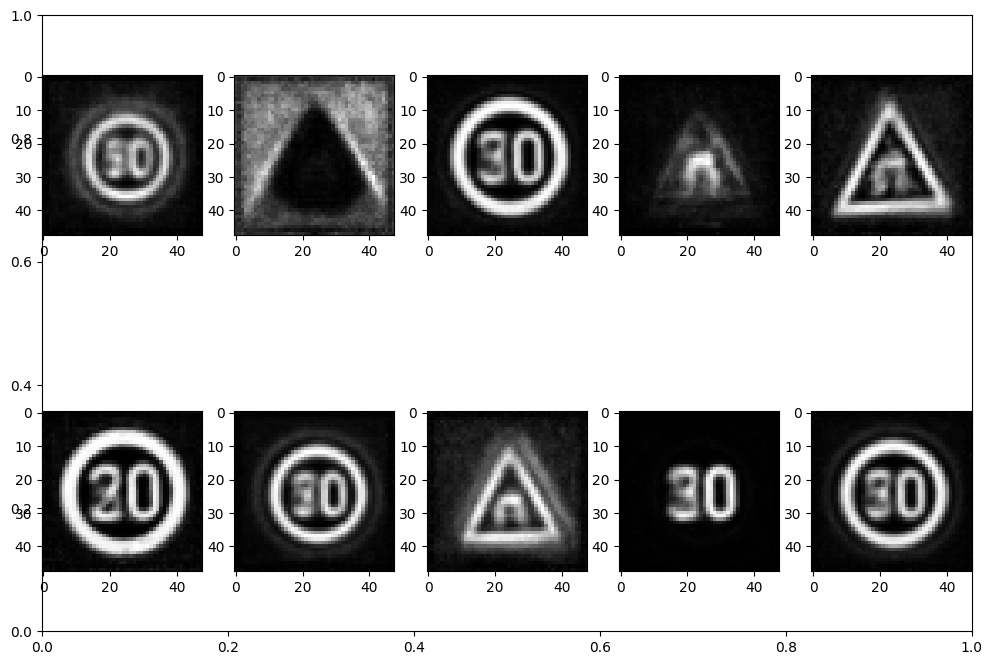

In [779]:
fig,ax = plt.subplots(figsize=(12,8))
for centroid in range(len(kmeans.cluster_centers_)):
    plt.subplot(2,5,centroid+1)
    plt.imshow(kmeans.cluster_centers_[centroid].reshape(48,48),cmap='grey')

In [780]:
y_pred = kmeans.predict(complete_x_test)

In [781]:
accuracy_score(y_pred,complete_y_test)

0.23300970873786409

In [783]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

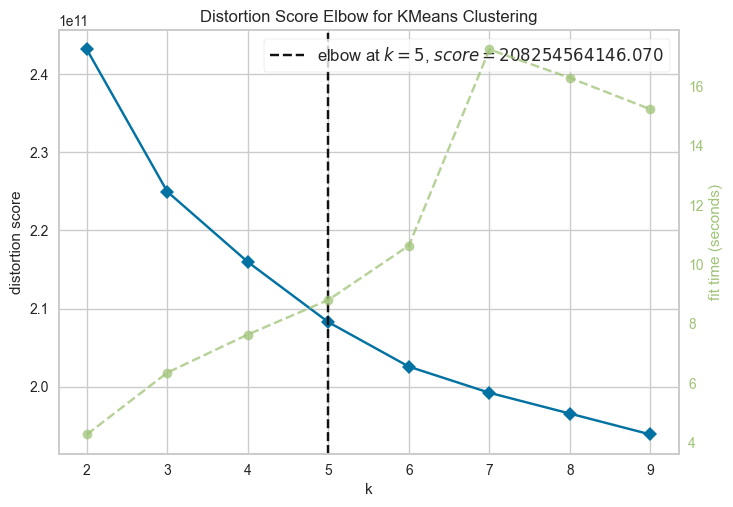

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [788]:
visualizer = KElbowVisualizer(kmeans, k=(2,10))
 
visualizer.fit(pd.DataFrame(upgraded)) 
visualizer.show()  